In [1]:
%load_ext lab_black

In [2]:
import itertools
import string
import sys
from collections import defaultdict
from pathlib import Path

import cytoolz as tlz
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygeohydro.plot as gh
import utide
import utils
import xarray as xr
from tqdm.auto import tqdm

In [3]:
CLASSES = {
    "C1": "w/o Estuary",
    "C2": "Triangular Estuary",
    "C3": "Trapezoidal Estuary",
}

SCNEARIOS = {
    "Ref": "Reference",
    "R20": "Roughness 0.020",
    "R30": "Roughness 0.030",
    "D90": "Discharge 90 cms",
    "D570": "Discharge 570 cms",
    "S07": "Surge Peak 0.77 m",
    "S31": "Surge Peak 3.15 m",
}

SAVE_KWDS = {"bbox_inches": "tight", "dpi": 300, "facecolor": "w"}

LABELS = {
    "S1": "Ref",
    "S2_1": "R20",
    "S2_2": "R30",
    "S4_1": "D90",
    "S4_2": "D570",
    "S5_1": "S07",
    "S5_2": "S31",
}

In [4]:
def _decompose(water_level, time, lat):
    coef = utide.solve(
        time,
        water_level,
        lat=lat,
        method="robust",
        conf_int="MC",
        verbose=False,
    )
    return dict(zip(coef["name"], coef["A"])), dict(zip(coef["name"], coef["g"]))

In [5]:
def decompose(case_path, lat):
    wl = xr.open_dataset(case_path, chunks="auto")["mesh2d_s1"]
    config = utils.read_config(case_path.parent.joinpath("inputs.txt"))

    nx = wl.mesh2d_face_x.values
    ny = wl.mesh2d_face_y.values
    ctr = np.where((nx > (config["x_center"] - 300)) & (nx < config["x_center"]))[0]
    wl_ctr = wl.isel(mesh2d_nFaces=ctr)

    time = wl_ctr.time
    dim = wl_ctr.mesh2d_nFaces.shape[0]
    amp, phs = [
        pd.DataFrame(d)[::-1].reset_index(drop=True)
        for d in zip(
            *[_decompose(wl_ctr.isel(mesh2d_nFaces=n), time, lat) for n in range(dim)]
        )
    ]
    amp["x"] = ny[ctr[::-1]] * 1e-3
    phs["x"] = ny[ctr[::-1]] * 1e-3
    return amp, phs

In [6]:
root = Path("..", "data")
out_path = Path(root, "outputs")
img_path = Path(root, "figures")
sim_path = Path(Path.home(), "repos", "dev", "results")

params = {
    "Discharge": ("D90", "D570"),
    "Roughness": ("R20", "R30"),
    "Surge": ("S07", "S31"),
}
variables = ["mesh2d_s1", "mesh2d_ucmag"]
class_list = [1, 2, 3]

stations = gpd.read_feather(Path(out_path, "gulf_east_wl_stations.feather")).set_index(
    "id"
)
lat = stations.loc["8534720"].lat

In [7]:
case_list = list(
    itertools.product(class_list, tlz.concat(list(params.values()) + [("Ref",)]))
)
with tqdm(
    total=len(case_list), desc="Tide decomposition", file=sys.stdout, position=0
) as pbar:
    for cl, cs in case_list:
        cpath = utils.get_path(cs, cl, sim_path)
        cname = cpath.parent.name
        pbar.set_postfix_str(cname)
        amp_path = Path(out_path, "tides", f"amplitude_{cname}.parquet")
        phs_path = Path(out_path, "tides", f"phase_{cname}.parquet")
        if not (amp_path.exists() and phs_path.exists()):
            amp, phs = decompose(cpath, lat)
            amp.to_parquet(amp_path)
            phs.to_parquet(phs_path)
        pbar.update(1)

Tide decomposition:   0%|          | 0/21 [00:00<?, ?it/s]

In [8]:
_amps = {}
principals = ["M2", "S2", "N2", "K1", "O1", "M4", "M6", "S4"]
cols = principals + ["x"]
for c in class_list:
    cnames = utils.get_case(c)
    _amps[f"C{c}"] = {
        s: pd.read_parquet(Path(out_path, "tides", f"amplitude_{f}.parquet"))[cols]
        for s, f in cnames.items()
    }

amps = {}
for c, a in _amps.items():
    amps[c] = {p: pd.DataFrame({s: a[s][p] for s in LABELS.values()}) for p in cols}
del _amps

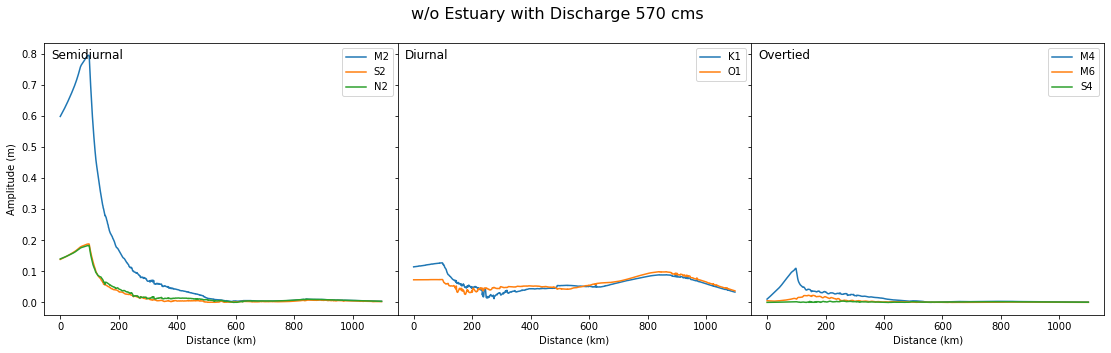

In [9]:
fig, axs = plt.subplots(
    1,
    3,
    figsize=(19, 5),
    sharex=True,
    sharey=True,
    gridspec_kw={"hspace": 0, "wspace": 0},
)
cats = [principals[:3], principals[3:5], principals[5:]]
cat_names = ["Semidiurnal", "Diurnal", "Overtied"]

cl, sc = "C1", "D570"
tides = pd.DataFrame({p: amps[cl][p][sc] for p in principals})
for i, (p, c) in enumerate(zip(cats, cat_names)):
    tides[p].plot(ax=axs[i])
    axs[i].set_title(c, loc="left", y=0.92, x=0.02)
    axs[i].set_xlabel("Distance (km)")
axs[0].set_ylabel("Amplitude (m)")
fig.suptitle(f"{CLASSES[cl]} with {SCNEARIOS[sc]}", size=16)
fig.savefig(Path(img_path, "tide_constituents_example.png"), **SAVE_KWDS)

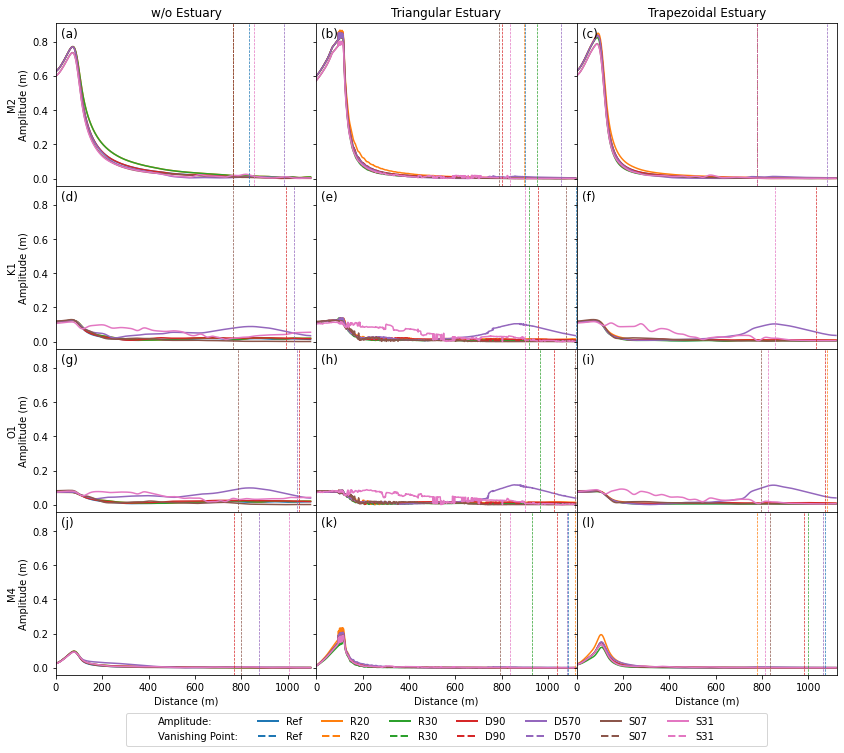

In [10]:
fig, axs = plt.subplots(
    4,
    3,
    figsize=(14, 12),
    sharex=True,
    sharey=True,
    gridspec_kw={"hspace": 0, "wspace": 0},
)

tide_plt = ["M2", "K1", "O1", "M4"]
tcs = list(tlz.partition(3, itertools.product(tide_plt, CLASSES)))
vanish_pts = {}
alphabest = [f"({s})" for s in string.ascii_lowercase[: len(axs) * len(axs[0])]]
fig_label = list(tlz.partition(len(axs[0]), alphabest))
for i in range(4):
    vp_x = defaultdict(dict)
    for j in range(3):
        tc, cl = tcs[i][j]
        ax = axs[i][j]
        text = fig_label[i][j]

        win_width = int(
            0.02 * amps[cl]["x"]["Ref"].max() / amps[cl]["x"]["Ref"].diff().max()
        )
        indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=win_width)
        amp = amps[cl][tc].rolling(window=indexer, min_periods=1).mean()
        amp = amp.iloc[::-1].rolling(window=indexer, min_periods=1).mean().iloc[::-1]
        amp = amp.rolling(window=indexer, min_periods=1).mean()
        lines = ax.plot(amp)
        colors = [line.get_color() for line in lines]
        scenarios = amp.columns

        excd = gh.exceedance(amp)
        handles = []
        for c, s in zip(colors, scenarios):
            handles.append(
                [
                    plt.Line2D([0], [0], color=c, label=s, lw=2),
                    plt.Line2D([0], [0], color=c, label=s, lw=2, ls="--"),
                ]
            )
            vp_t = excd[excd[f"{s}_rank"] <= 70].iloc[-1][s]
            vp_idx = amp[s][
                amp[s].rolling(win_width, center=True).max() > vp_t
            ].last_valid_index()
            if len(amp) - vp_idx >= win_width:
                vp_x[cl][s] = amps[cl]["x"].iloc[vp_idx - win_width][s]
                ax.axvline(vp_x[cl][s], ls="--", c=c, lw=0.7)
            else:
                vp_x[cl][s] = np.nan

        handles = (
            [
                plt.Line2D([0], [0], color="w", label="Amplitude:"),
                plt.Line2D([0], [0], color="w", label="Vanishing Point:"),
            ]
            + list(tlz.concat(handles))
            + [plt.Line2D([0], [0], color="w")]
        )
        ax.text(
            0.02,
            0.97,
            text,
            size=12,
            horizontalalignment="left",
            verticalalignment="top",
            transform=ax.transAxes,
        )
        ax.margins(x=0)
        if i == 0:
            ax.set_title(CLASSES[cl])
        if j == 0:
            ax.set_ylabel(f"{tc}\nAmplitude (m)")
        if i == 3:
            ax.set_xlabel("Distance (m)")
        if i == 3 and j == 1:
            legends = [f"{s} (Amp.)" for s in amp.columns] + [
                f"{s} (VP)" for s in amp.columns
            ]
            ax.legend(
                handles=handles,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.2),
                ncol=len(amp.columns) + 2,
            )
    vanish_pts[tc] = pd.DataFrame(vp_x)
fig.savefig(Path(img_path, "vanishing_point.png"), **SAVE_KWDS)

In [11]:
for c, df in vanish_pts.items():
    df.to_csv(Path(out_path, f"vp_{c}.csv"))

In [12]:
def get_nan(vp):
    idx = [
        vp.iloc[i : i + 1, j : j + 1].to_dict() for i, j in zip(*np.where(vp.isna()))
    ]
    vp_list = [(k, list(v.keys())[0]) for d in idx for k, v in d.items()]
    vps = defaultdict(list)
    for c, s in vp_list:
        vps[c].append(s)
    return vps


missing = pd.DataFrame({tc: get_nan(vp) for tc, vp in vanish_pts.items()})
missing = missing.fillna("").applymap(", ".join)
missing.to_csv(Path(out_path, "missing_vp.csv"), sep=" ")

In [13]:
cl, tc, s = "C3", "S2", "R30"
amp = amps[cl][tc].rolling(window=indexer, min_periods=1).mean()
amp = amp.iloc[::-1].rolling(window=indexer, min_periods=1).mean().iloc[::-1]
amp = amp.rolling(window=indexer, min_periods=1).mean()
excd = gh.exceedance(amp)
vp = {}
vp_x = {}
probs = {60: "g", 70: "r", 80: "k"}
for p in probs:
    vp[p] = excd[excd[f"{s}_rank"] <= p].iloc[-1][s]
    vp_idx = amp[s][
        amp[s].rolling(win_width, center=True).max() > vp[p]
    ].last_valid_index()
    if len(amp) - vp_idx >= win_width:
        vp_x[p] = amps[cl]["x"].iloc[vp_idx - win_width][s]

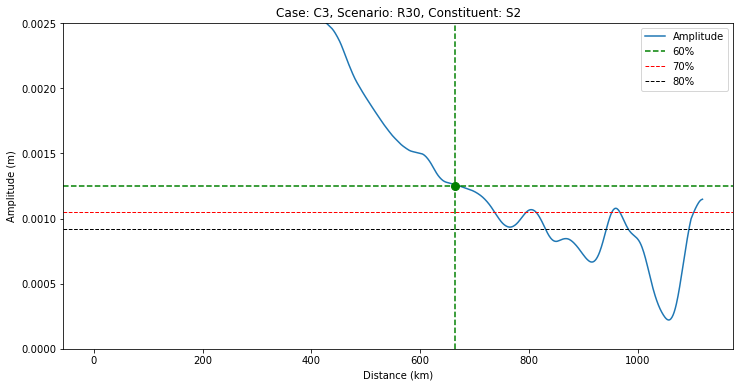

In [14]:
ax = amp[s].plot(figsize=(12, 6))
for p, t in vp.items():
    lw = 1.5 if p in vp_x else 1
    ax.axhline(t, ls="--", c=probs[p], lw=lw)
for p, x in vp_x.items():
    ax.plot(x, vp[p], "go", markersize=8)
    ax.axvline(x, ls="--", c=probs[p], lw=1.5)
ax.set_ylim(0, vp[p] * 2)
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Amplitude (m)")
ax.legend(["Amplitude", *[f"{p}%" for p in probs]])
ax.set_title(f"Case: {cl}, Scenario: {s}, Constituent: {tc}")
ax.figure.savefig(Path(img_path, "vanishing_point_example.png"), **SAVE_KWDS)